In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import copy
import random
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)# arry 数字 不用科学计数法

In [2]:
# 公用变量
hour_str=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

In [3]:
##########################  公用函数    ################

#找出凸集
def is_convex(temp,n):
    lat,lon = temp['lat_plot'][n],temp['lon_plot'][n]
    temp1 = temp[temp['lat_plot']>lat]
    temp2 = temp[temp['lat_plot']<lat]
    temp3 = temp[temp['lon_plot']>lon]
    temp4 = temp[temp['lon_plot']<lon]
    if len(temp1)*len(temp2)*len(temp3)*len(temp4) == 0:
        return True
    elif sum(temp1['lon_plot']>lon)*sum(temp1['lon_plot']<lon) == 0:
        return True
    elif sum(temp2['lon_plot']>lon)*sum(temp2['lon_plot']<lon) == 0:
        return True
    elif sum(temp3['lat_plot']<lat)*sum(temp3['lat_plot']>lat) == 0:
        return True
    elif sum(temp4['lat_plot']<lat)*sum(temp4['lat_plot']>lat) == 0:
        return True
    else:
        return False
    
# 获取两站点间的距离
def station_dist(station1_id,station2_id,sta_loc):
    a = list(sta_loc[sta_loc['station_id']==station1_id]['lat'])[0]
    b = list(sta_loc[sta_loc['station_id']==station2_id]['lat'])[0]
    c = list(sta_loc[sta_loc['station_id']==station1_id]['lon'])[0]
    d = list(sta_loc[sta_loc['station_id']==station2_id]['lon'])[0]
    return (a-b)**2+(c-d)**2

# 将站点名称统一转为str
def st_id2_str(df,col):
    str_st,index_i = [],[]
    for i in df.index:
        if '.' not in str(df[col][i]):
            pass
        elif len(str(df[col][i])) == 6:
            str_st.append(str(df[col][i])+'0s')
            index_i.append(i)
        elif len(str(df[col][i])) == 7:
            str_st.append(str(df[col][i])+'s')
            index_i.append(i)
        else:
            pass
    df = df[(df.index).isin(index_i)]
    df[col] = str_st
    return df

# 获取当日活动站点状态信息
def get_status(status_df,sta_loc):
    N_O_name = pd.read_csv('E:/CitiBike/y0_output/new_old_name.csv',index_col = 0)
    N_O_name = st_id2_str(N_O_name,'short_name') # 转换站点id数据格式
    N_O_name = N_O_name[(N_O_name['legacy_id']).isin(list(status_df['station_id']))]#与状态数据交叠
    N_O_name = N_O_name[(N_O_name['short_name']).isin(list(sta_loc['station_id']))]#与24日当天活动站点的交叠
    N_O_name.columns = ['station_id','name2']
    temp = pd.merge(N_O_name,status_df,on='station_id')#与状态数据合并
    temp = temp[['name2','num_docks_available','num_bikes_available']]
    temp.columns = ['station_id','docks_available','bikes_available']
    return temp

In [4]:

#************************************** 5.1 分区  *****************************************


In [4]:
# 5.1.0  骑行距离统计  表4-1

def get_trip_dist(month):
    trips = pd.read_csv('E:/CitiBike/ori_data/'+month+'-citibike-tripdata.csv')[['start_lat','start_lng','end_lat','end_lng']]
    length = len(trips)
    sa,sl,ea,el = list(trips['start_lat']),list(trips['start_lng']),list(trips['end_lat']),list(trips['end_lng'])
    trip_dist = []
    for i in range(length):
        try:
            trip_dist.append(np.sqrt((sa[i]-ea[i])**2+(sl[i]-el[i])**2)*111000)
        except:
            pass
    # 统计
    K = int(max(trip_dist)/500)+1
    trip_dist = pd.Series(trip_dist)
    trip_dist_dc = {}
    for i in range(K):
        a,b = i*500,(i+1)*500
        trip_dist = trip_dist[trip_dist>=a]
        trip_dist_dc[str(a)+'-'+str(b)] = sum(trip_dist<b)
    return trip_dist_dc
Trip_Dist = []
Trip_Dist.append(get_trip_dist('202102'))
Trip_Dist.append(get_trip_dist('202103'))
Trip_Dist.append(get_trip_dist('202104'))
Trip_Dist.append(get_trip_dist('202105'))
Trip_Dist.append(get_trip_dist('202106'))
Trip_Dist.append(get_trip_dist('202107'))
Trip_Dist.append(get_trip_dist('202108'))
Trip_Dist.append(get_trip_dist('202109'))
Trip_Dist.append(get_trip_dist('202110'))
Trip_Dist.append(get_trip_dist('202111'))
Trip_Dist.append(get_trip_dist('202112'))
Trip_Dist.append(get_trip_dist('202201'))

for i in range(1,len(Trip_Dist)):
    for j in Trip_Dist[i].keys():
        try:
            Trip_Dist[0][j] = Trip_Dist[0][j] + Trip_Dist[i][j]
        except:
            Trip_Dist[0][j] = Trip_Dist[i][j]
print(Trip_Dist[0])
del Trip_Dist

{'0-500': 3273099, '500-1000': 4585543, '1000-1500': 4813409, '1500-2000': 3787552, '2000-2500': 2856733, '2500-3000': 2082905, '3000-3500': 1537910, '3500-4000': 1126676, '4000-4500': 832858, '4500-5000': 631940, '5000-5500': 482995, '5500-6000': 374930, '6000-6500': 291057, '6500-7000': 223113, '7000-7500': 165005, '7500-8000': 124170, '8000-8500': 90169, '8500-9000': 67884, '9000-9500': 51451, '9500-10000': 38810, '10000-10500': 28306, '10500-11000': 21397, '11000-11500': 15489, '11500-12000': 11971, '12000-12500': 8429, '12500-13000': 6747, '13000-13500': 4678, '13500-14000': 3702, '14000-14500': 2816, '14500-15000': 1929, '15000-15500': 1567, '15500-16000': 1486, '16000-16500': 1136, '16500-17000': 825, '17000-17500': 705, '17500-18000': 555, '18000-18500': 488, '18500-19000': 293, '19000-19500': 275, '19500-20000': 178, '20000-20500': 208, '20500-21000': 102, '21000-21500': 62, '21500-22000': 53, '22000-22500': 23, '22500-23000': 14, '23000-23500': 14, '23500-24000': 6, '24000-24

In [4]:
###  数据准备
today = '2022-01-25'
N = pd.read_csv("E:/CitiBike/ori_data/"+today[0:4]+today[5:7]+"-citibike-tripdata.csv",index_col=0)[['started_at','ended_at','start_station_id','end_station_id']]
temp1 = N[N.index.isin( [x for x in N.index if (N['started_at'][x])[0:10]==today])][['start_station_id']]
temp2 = N[N.index.isin( [x for x in N.index if (N['ended_at'][x])[0:10]==today])][['end_station_id']]
del N
temp1,temp2 = st_id2_str(temp1,'start_station_id'),st_id2_str(temp2,'end_station_id')
sta_loc = pd.read_csv("E:/CitiBike/xls_operate/sta_loc.csv",index_col=0).to_dict()#excel操作oridata里的文件而得
# 各站点 借还车需求
X={}
#st_list = set(temp1['start_station_id'])|set(temp2['end_station_id'])
#pd.Series(X.index).to_csv('E:/CitiBike/y5_output/st_list.csv')
st_list  = list(pd.read_csv('E:/CitiBike/y5_output/st_list.csv')['0'])# 站点顺序 要固定
for st_id in st_list:
    X[st_id] = [sum(temp1['start_station_id']==st_id),sum(temp2['end_station_id']==st_id),sta_loc['lat'][st_id],sta_loc['lon'][st_id]]
X = pd.DataFrame(X,index=['demand','return','lat_plot','lon_plot']).T
X['net_demand'] = X['demand'] - X['return']

In [5]:
#  5.1.1  零需求站点集 的生成
def get_next_id(ids_list, sum_net_demand, threshold, not_add_ids):
    temp0 = X[(X.index).isin(ids_list)]
    lat_bar,lon_bar = np.mean(temp0['lat_plot']),np.mean(temp0['lon_plot'])#坐标中心
    net_sum,d_sum = sum(temp0['net_demand']),sum(temp0['demand'])+sum(temp0['return'])#净需求和总需求累积量
    if  net_sum >= -1*d_sum*0.01 and net_sum<= d_sum*0.02:
        st_id,is_end = [],1
    else:
        temp4 = [x for x in not_add_ids if x not in District[distri_id]]
        temp = X[(X.index).isin(temp4)]# 获取周围站点
        temp1 = temp[(temp['lat_plot']>=(lat_bar-threshold)) & (temp['lat_plot']<=(lat_bar+threshold))]
        temp2 = temp1[(temp1['lon_plot']>=(lon_bar -threshold)) & (temp1['lon_plot'] <= (lon_bar+threshold))]
        st_id,is_end = 'null',1    
        if len(temp2) == 1:
            st_id = list(temp2.index)
            net_sum += list(temp2['net_demand'])[0]
            d_sum += list(temp2['demand'])[0] + list(temp2['return'])[0]
            if net_sum < d_sum*-0.01 or net_sum > d_sum*0.02:
                is_end = 0
        elif len(temp2) > 1:
            station_Dist = []# 计算距离
            station_net,station_sum = [],[]# 计算净需求之和.总需求之和
            for j in temp2.index:
                station_Dist.append((temp2['lat_plot'][j] - lat_bar)**2 + (temp2['lon_plot'][j]-lon_bar)**2) 
                station_net.append(abs(X['net_demand'][j] + net_sum))
                station_sum.append(X['demand'][j] + X['return'][j] + d_sum)
            temp2['dist'],temp2['net'],temp2['sum'] = station_Dist,station_net,station_sum
            temp3 = temp2.sort_values(by='dist')
            st_id, is_end =[], 0
            for i in temp3.index[0:max_ids-len(ids_list)]:
                d_sum += temp3['demand'][i] + temp3['return'][i]
                net_sum += temp3['net_demand'][i]  
                st_id.append(i)
                if net_sum >= d_sum*-0.01 and net_sum<= d_sum*0.02:
                    is_end = 1
                    break
    return st_id,is_end
            
not_add_ids = list(X.index)# 还没加入群的站点（初始）
threshold = 0.015# 距离阈值
distri_id = 0# 组ID 从0开始
District = {}# 存放组id 和 站点id
max_ids = 20 # 一个组容纳最多站点数
poor_sts = []
convex_sts_last,con_sig  = [],[]
for k in range(200):
    temp_X = X[(X.index).isin(not_add_ids)]
    temp_X = temp_X[~(temp_X.index).isin(poor_sts)]
    temp_X = temp_X[~(temp_X.index).isin(con_sig)]
    if len(temp_X) == 0:
            break
    else:
        if k < 1:
            convex_sts = X[X['net_demand']>=10].index
            convex_sts = X[X['net_demand']<=-10].index
        else:
            convex_sts = [i for i in temp_X.index if is_convex(temp_X,i)] 
        if len(convex_sts) == len(convex_sts_last) and list(convex_sts)==list(convex_sts_last):
            con_sig += list(convex_sts)
            continue
        else:
            convex_sts_last = convex_sts
            print([len(not_add_ids),len(convex_sts)])
            for i in convex_sts:
                if i in not_add_ids:
                    District[distri_id] = [i]
                    sum_net_demand = X['net_demand'][i]#初值
                    for j in range(200):
                        if len(District[distri_id]) >= max_ids:
                            break
                        else:
                            st_id,is_end = get_next_id(District[distri_id], sum_net_demand, threshold,not_add_ids)
                            if st_id == 'null':
                                poor_sts += District[distri_id]
                                break
                            elif is_end == 1:
                                District[distri_id] += st_id
                                not_add_ids = [x for x in not_add_ids if x not in District[distri_id]]
                                distri_id += 1
                                break
                            else:
                                District[distri_id] += st_id
                                sum_net_demand = sum_net_demand + X['net_demand'][st_id]

[1477, 58]
[1168, 91]
[948, 55]
[808, 53]
[670, 40]
[590, 34]
[542, 36]
[510, 29]
[479, 40]
[407, 41]
[339, 34]
[285, 26]
[250, 31]
[221, 30]
[187, 25]
[180, 22]
[180, 23]
[145, 10]
[139, 16]
[121, 13]
[105, 14]
[95, 17]
[86, 12]
[85, 11]
[85, 12]
[75, 5]


In [11]:
#令上面 for k in range(2)
convex_sts_n = convex_sts

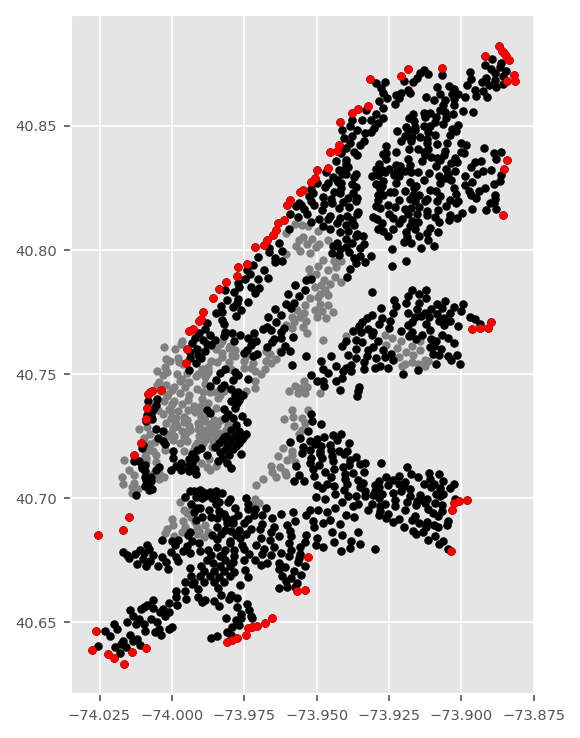

<Figure size 432x288 with 0 Axes>

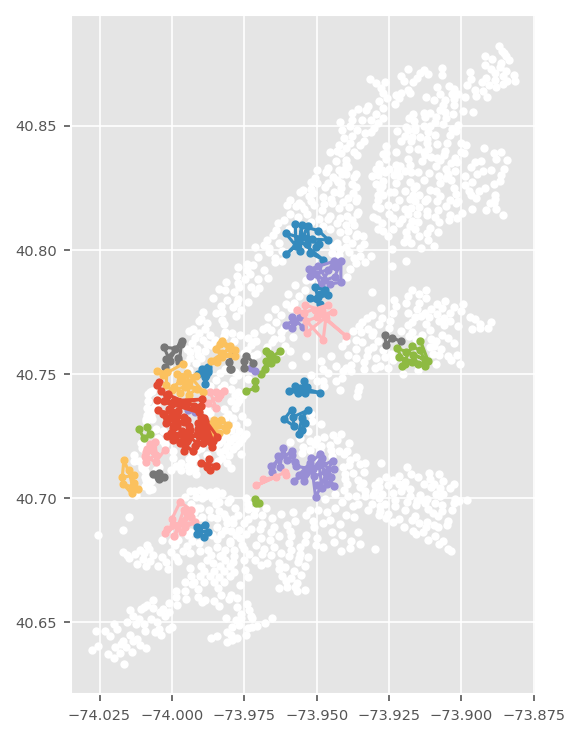

In [25]:
# 第一步之后  令上面 for k in range(1)   图4-1
plt.style.use('ggplot')#设置绘图风格
plt.figure(dpi=150,figsize=(4,6))
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.plot(X['lon_plot'],X['lat_plot'],'.',color='grey')
for i in not_add_ids:
    plt.plot(X['lon_plot'][i],X['lat_plot'][i],'k.')
for i in convex_sts_n:
    plt.plot(X['lon_plot'][i],X['lat_plot'][i],'r.')
plt.figure(2)
plt.figure(dpi=150,figsize=(4,6))
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
# 分组情况
plt.plot(X['lon_plot'],X['lat_plot'],'.',color='w')
for i in District.keys():
    temp = X[X.index.isin(District[i])]
    plt.plot(temp['lon_plot'],temp['lat_plot'],'.-')

In [27]:
#令上面 for k in range(3)
convex_sts_n = convex_sts

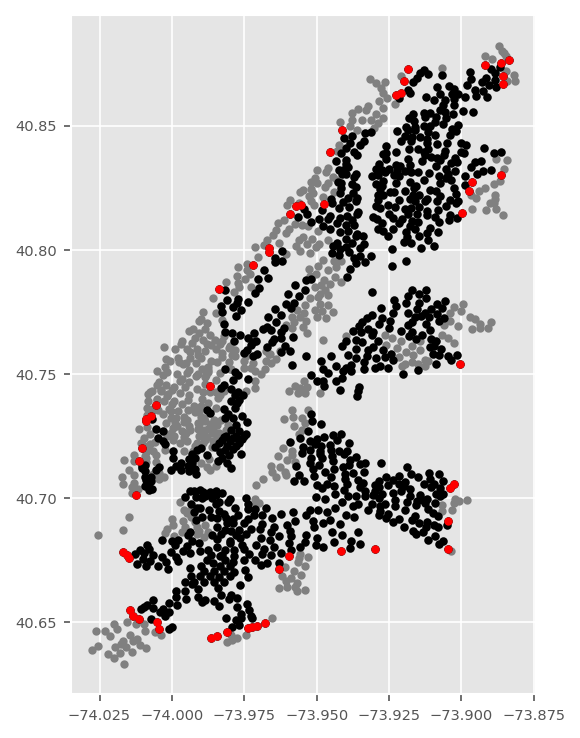

<Figure size 432x288 with 0 Axes>

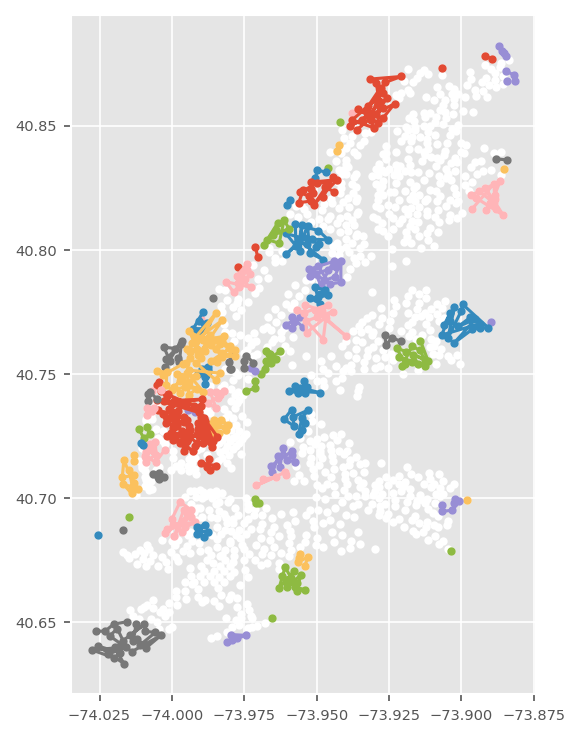

In [29]:
# 第一步之后  令上面 for k in range(2)   图4-2
plt.style.use('ggplot')#设置绘图风格
plt.figure(dpi=150,figsize=(4,6))
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.plot(X['lon_plot'],X['lat_plot'],'.',color='grey')
for i in not_add_ids:
    plt.plot(X['lon_plot'][i],X['lat_plot'][i],'k.')
for i in convex_sts_n:
    plt.plot(X['lon_plot'][i],X['lat_plot'][i],'r.')
plt.figure(2)
plt.figure(dpi=150,figsize=(4,6))
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
# 分组情况
plt.plot(X['lon_plot'],X['lat_plot'],'.',color='w')
for i in District.keys():
    temp = X[X.index.isin(District[i])]
    plt.plot(temp['lon_plot'],temp['lat_plot'],'.-')

In [6]:
# 5.1,2  站点集+落单点
District_2 = {}
st_added =[]
for i in District.keys():
    temp = X[(X.index).isin(District[i])]
    District_2[i] = [np.mean(temp['lon_plot']),np.mean(temp['lat_plot']),len(temp)] 
    st_added += list(temp.index)
for i in set(X.index)-set(st_added):
    District_2[i] = [X['lon_plot'][i],X['lat_plot'][i],1] 
temp = pd.DataFrame(District_2,index=['lon','lat','num']).T.sort_values(by='lat')

#  正式形成分区
not_add_set =  list(temp.index)
fen = {}
for i in temp.index:
    if i in not_add_set:
        dist = {}
        num_sum,friends = temp['num'][i],[]
        not_add_set.remove(i)
        for j in not_add_set:
            dist[j] =  np.sqrt((temp['lat'][i]-temp['lat'][j])**2+ (temp['lon'][i]-temp['lon'][j])**2)
        dist = pd.DataFrame(dist,index=['d']).T.sort_values(by='d')
        for j in dist.index:
            if dist['d'][j]>0.05:#   0.05   0,04
                break
            else:
                friends = friends+[j]
                num_sum += temp['num'][j]
                not_add_set.remove(j)
                if num_sum >= 80:#   90      70
                    break
        fen[i] = friends
# 还原
FEN = {}
for i in range(len(fen)):
    head_st =list(fen.keys())[i]
    st_li = []
    if type(head_st) != str:
        st_li += District[head_st]
    else:
        st_li += [head_st]
    for j in fen[head_st]:
        if type(j) != str:
            st_li += District[j]
        else:
            st_li += [j]
    FEN[i] = st_li
FEN[list(FEN.keys())[-2]] = FEN[list(FEN.keys())[-1]] + FEN[list(FEN.keys())[-2]] # 合并最后一个 仅3站点
del FEN[list(FEN.keys())[-1]]

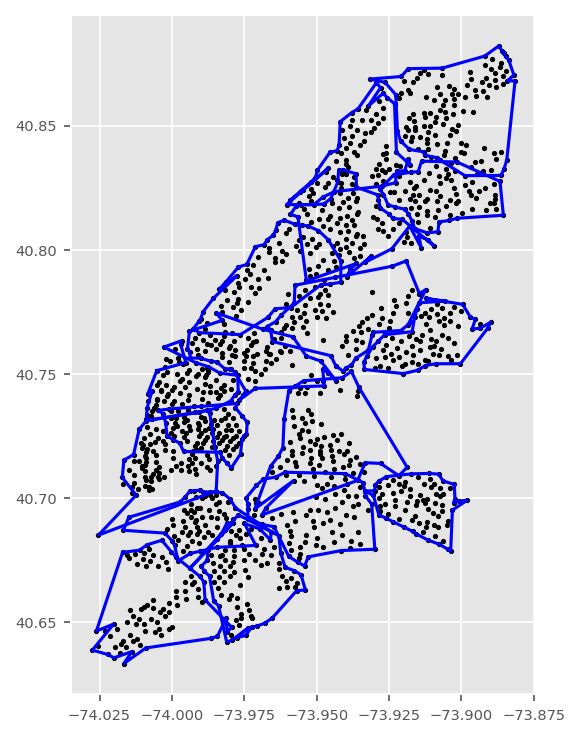

In [7]:
#画图 展示   图4-3
plt.style.use('ggplot')#设置绘图风格
plt.figure(dpi=150,figsize=(4,6))
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.plot(X['lon_plot'],X['lat_plot'],'k.',markersize=3)

def get_Dict_df(temp3):
    Dist_ay = np.zeros((len(temp3),len(temp3)))
    for i in range(len(temp3)):#计算距离
        lat_i,lon_i = list(temp3['lat_plot'])[i],list(temp3['lon_plot'])[i]
        for j in range(i+1,len(temp3)):
            lat_j,lon_j = list(temp3['lat_plot'])[j],list(temp3['lon_plot'])[j]
            Dist_ay[i,j] = np.sqrt((lat_i-lat_j)**2 + (lon_i-lon_j)**2)
    for i in range(len(temp3)):# 对角复制
        for j in range(i+1,len(temp3)):
            Dist_ay[j,i] = Dist_ay[i,j]
    for i in range(len(temp3)):# 对角线 inf
        Dist_ay[i,i] = 1000
    Dist_ay = pd.DataFrame(Dist_ay)# 转df
    return Dist_ay

def get_path_st(lat_plt,lon_plt,temp4,Dist_ay,sig):# 设计画图路径
    path_st = [0]
    for i in range(len(temp4)-1):
        next_id = Dist_ay[Dist_ay[path_st[-1]] == min(Dist_ay[path_st[-1]])].index[0]
        if next_id > path_st[-1]+1 and sig==1 and temp4['lon_plot'][next_id] > temp4['lon_plot'][path_st[-1]] and (path_st[-1]+1) not in path_st:
            next_id = path_st[-1] + 1
        #if next_id > path_st[-1]+1 and sig==2 and temp4['lat_plot'][next_id] > temp4['lat_plot'][path_st[-1]] and (path_st[-1]+1) not in path_st:
        #    next_id = path_st[-1] + 1
        if next_id > path_st[-1]+1 and sig==3 and temp4['lat_plot'][next_id] < temp4['lat_plot'][path_st[-1]] and (path_st[-1]+1) not in path_st:
            next_id = path_st[-1] + 1
        #if next_id > path_st[-1]+1 and sig==4 and temp4['lon_plot'][next_id] < temp4['lon_plot'][path_st[-1]] and (path_st[-1]+1) not in path_st:
            #next_id = path_st[-1] + 1
        path_st.append(next_id)
        Dist_ay = Dist_ay.drop(index = path_st[-2])
    for i in path_st:
        lat_plt.append(temp4['lat_plot'][i])
        lon_plt.append(temp4['lon_plot'][i])
    return lat_plt,lon_plt

for i in FEN.keys():
    temp = X[(X.index).isin(FEN[i])]
    convex_sts = [n for n in temp.index if is_convex(temp,n)] 
    temp2 =(X[(X.index).isin(convex_sts)])
    avg_lat = np.mean(temp2['lat_plot'])
    temp3,temp4 = temp2[temp2['lat_plot']>=avg_lat],temp2[temp2['lat_plot']<avg_lat]
    avg_lon1,avg_lon2 =  np.mean(temp3['lon_plot']),np.mean(temp4['lon_plot'])
    temp1,temp2 = temp3[temp3['lon_plot']<avg_lon1].sort_values(by='lat_plot'),temp3[temp3['lon_plot']>=avg_lon1].sort_values(by='lon_plot')
    temp3,temp4 = temp4[temp4['lon_plot']>=avg_lon2].sort_values(by='lon_plot',ascending=False),temp4[temp4['lon_plot']<avg_lon2].sort_values(by='lat_plot')
    temp2['compare'] = -1*temp2['lat_plot']+temp2['lon_plot']
    temp4['compare'] = temp4['lat_plot']-temp4['lon_plot']
    lat_plt,lon_plt = [],[]
    lat_plt,lon_plt = get_path_st(lat_plt,lon_plt,temp1,get_Dict_df(temp1),1)
    lat_plt,lon_plt = lat_plt+list(temp2.sort_values(by='compare')['lat_plot']),lon_plt+list(temp2.sort_values(by='compare')['lon_plot'])
    lat_plt,lon_plt = get_path_st(lat_plt,lon_plt,temp3,get_Dict_df(temp3),3)
    lat_plt,lon_plt = lat_plt+list(temp4.sort_values(by='compare')['lat_plot']),lon_plt+list(temp4.sort_values(by='compare')['lon_plot'])
    plt.plot(lon_plt+[lon_plt[0]],lat_plt+[lat_plt[0]],'b-')

In [158]:
# 5.2   调度算法 —————

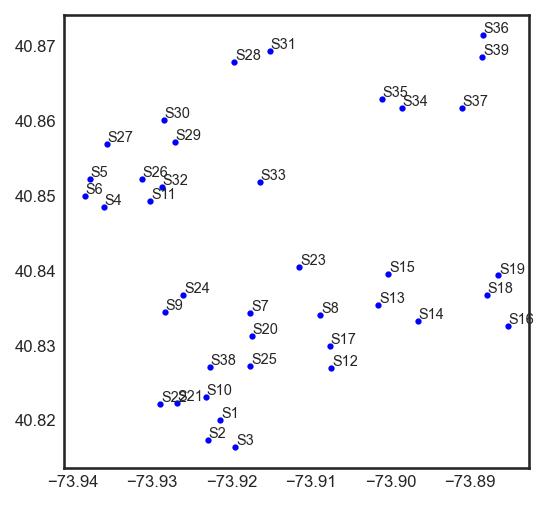

In [8]:
# 5.2.0 站点对象和基本信息 图4-7

## 求解得 回收/投放 单车数量
sample_sts = pd.read_csv("E:/CitiBike/xls_operate/example39.csv",index_col=0)#excel选取sta_loc.csv部分而得
status_df = pd.read_csv("E:/CitiBike/y0_output/2022-01-25-10-43-57.csv",index_col=0)#2022-01-25-10-43-57,2022-01-25-00-59-24
sta_loc = pd.read_csv("E:/CitiBike/xls_operate/sta_loc.csv")#站点坐标数据
temp = get_status(status_df,sta_loc)
status_df = temp[(temp['station_id']).isin(sample_sts.index)]
status_df['Capcity'] = status_df['docks_available']+status_df['bikes_available']
status_df.index = range(len(status_df))

# 地理坐标。用于画图
LON_find, LAT_find = [],[]
for i in status_df['station_id']:
    temp = sta_loc[sta_loc['station_id']==i]
    LON_find.append(list(temp['lon'])[0])
    LAT_find.append(list(temp['lat'])[0])
# 39个站点
plt.style.use('seaborn-white')#设置绘图风格
plt.figure(dpi=150,figsize=(4,4))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.plot(LON_find,LAT_find,'b.',markersize=4)
for i in range(len(sample_sts)):
    plt.text( LON_find[i]+0.0001,LAT_find[i]+0.0003,'S'+str(i+1),fontsize=7)

In [9]:
# 表 4-2的来源
status_df

,station_id,docks_available,bikes_available,Capcity
0,7901.04s,1,18,19
1,7863.03s,9,23,32
2,7840.05s,11,7,18
3,8336.02s,29,6,35
4,8399.06s,30,0,30
5,8358.03s,23,0,23
6,8126.07s,30,0,30
7,8122.04s,2,18,20
8,8149.09s,19,0,19
9,7962.01s,14,7,21


In [10]:
# 5.2.1 调度模型的变量

# 数据准备的设置 -----------------------
Gi = status_df['bikes_available']# 调度前初始单车辆 gi

Ci = status_df['Capcity']# 站点容量Ci

Dij = np.zeros((len(status_df),len(status_df)))# 距离 Dij
for i in range(len(status_df)-1):
    for j in range(i+1,len(status_df)):
        Dij[i,j] = np.sqrt(station_dist(status_df['station_id'][i],status_df['station_id'][j],sta_loc))*111000
for i in range(len(status_df)):
    for j in range(0,i):
        Dij[i,j] = Dij[j,i]
        
# 对应关系 F（x） 一整天的
Fx = pd.read_csv('E:/CitiBike/y4_output/FX_all_day.csv',index_col=0)[list(status_df['station_id'])]
Fx = (Fx.dropna(axis=0,how='all')).to_dict()

### 常量的设置-----------------------
Q = 40 #设货车容量为40
n = len(status_df)# 决策变量个数
new_Fx=[]# 各站点最优库存
for i in range(n):
    a = pd.DataFrame([Fx[list(Fx.keys())[i]]],index=['ex']).T
    min_v = min(a['ex'])
    b = list(a[a['ex'] == min_v].index)
    new_Fx.append(np.mean(b))

In [11]:
Fx

{'7901.04s': {0: 2.486681567223014,
  1: 1.6283219329918903,
  2: 0.9885302912399134,
  3: 0.55986150658071,
  4: 0.2955314307678438,
  5: 0.1451603601525652,
  6: 0.0661975511006887,
  7: 0.0279842283034085,
  8: 0.0109894427155984,
  9: 0.0041210033924684,
  10: 0.0018758515813516,
  11: 0.0021958259075568,
  12: 0.0054951009122174,
  13: 0.0150112028007699,
  14: 0.0386651646237687,
  15: 0.0923595309763232,
  16: 0.2041856724998659,
  17: 0.4183692254491284,
  18: 0.7942509711746292,
  19: 1.3865241758022475,
  20: nan,
  21: nan,
  22: nan,
  23: nan,
  24: nan,
  25: nan,
  26: nan,
  27: nan,
  28: nan,
  29: nan,
  30: nan,
  31: nan,
  32: nan,
  33: nan,
  34: nan,
  35: nan},
 '7863.03s': {0: 1.7880942100181438,
  1: 1.3435184301693404,
  2: 0.9942326410597704,
  3: 0.7210381010641945,
  4: 0.5109721211491406,
  5: 0.3529848023825062,
  6: 0.2374357100447813,
  7: 0.1554204468550805,
  8: 0.099013061093574,
  9: 0.0615180940801776,
  10: 0.0375874119933263,
  11: 0.023219963

In [12]:
# 假使没有调度工作  成本会有？
sum_c = 0
for i in status_df.index:
    sum_c += Fx[status_df['station_id'][i]][status_df['bikes_available'][i]]
sum_c*2

56.55750145585342

In [13]:
# ❀❀❀❀❀❀❀❀
# ❀  函数集  ❀
# ❀❀❀❀❀❀❀❀
# =========================================  生成 初始解  =======================================================
import random
def next_ststion(path,now_station_lat,now_station_lon,sig):
    temp = sample_sts[~(sample_sts.index).isin(path)]
    temp['距离'] = (temp['lat_plot']-now_station_lat)**2+(temp['lon_plot']-now_station_lon)**2
    if len(temp)==1:
        rand_int = 0
    elif sig == 2 or len(temp)==2:
        rand_int = random.randint(0,1)
    else:
        rand_int = random.randint(0,2)
    temp = temp.sort_values(by='距离')
    return list(temp.index)[rand_int],list(temp['lat_plot'])[rand_int],list(temp['lon_plot'])[rand_int]

def ori_solution(sig):
    path,loc_lat,loc_lon = [],[],[]
    path.append(next_ststion(path,path_0_lat,path_0_lon,sig)[0])
    loc_lat.append(next_ststion(path,path_0_lat,path_0_lon,sig)[1])
    loc_lon.append(next_ststion(path,path_0_lat,path_0_lon,sig)[2])
    for i in range(len(sample_sts)-1):
        a,b,c = next_ststion(path,loc_lat[-1],loc_lon[-1],sig)
        path.append(a)
        loc_lat.append(b)
        loc_lon.append(c)
    return path,loc_lat,loc_lon

# ==========================================  求解优化模型，得X ===============================================
import cvxpy as cp
#目标函数
def objective(x):
    z2 = 0
    # Fi 辅助变量 调度之后的库存
    for i in range(len(Gi)):
        Fi = Gi[i] + x[i] 
        z2 += cp.abs(new_Fx[i]-Fi)
    return z2 

#约束条件
def constri(path_id):

    cons1 = 'con = ['    # fi>0, fi<容量
    for carg1 in range(n):
        cons1 += str(Gi[carg1]) + '+x['+ str(carg1)+'] >= 0, '+str(Gi[carg1]) + '+x['+ str(carg1)+'] <= '+str(Ci[carg1])+', '
        
    for carg1 in range(1,n): # Lij载重不超过Q,  Lij载重>0不超过Q
        cons1 += '-1*('
        for pa_id in path_id[0:carg1]:
            cons1+='x['+str(pa_id)+']+'
        cons1 = cons1[:-1]+')>=0,'
        cons1 += '-1*('
        for pa_id in path_id[0:carg1]:
            cons1+='x['+str(pa_id)+']+'
        cons1 = cons1[:-1]+')<= '+str(Q)+','
    
    cons1 = cons1 + 'cp.sum(x)==0 ]'# 空车出发，空车回来
    return cons1

# ==========================================  求 [z1,z2] =====================================================
def get_many(X,path_id):
    # 需求损失z2 ############################
    z2 = 0
    for i in range(n):
        Fi = Gi[i] + X[i]
        z2 += Fx[list(Fx.keys())[i]][Fi]   

    # 路径成本z1 ############################
    path2 = []#更新路径
    for i in range(n):
        if X[path_id[i]]!=0:
            path2.append(status_df['station_id'][path_id[i]])
    
    R = np.zeros((n,n))#路径矩阵 Rij
    path_0 = list(status_df['station_id']).index(path2[0])
    for i in range(n):
        try:
            a = path2.index(status_df['station_id'][i])
        except:
            continue
        if a < len(path2)-1:
            R[i,list(status_df['station_id']).index(path2[a+1])] = 1
        else:
            R[i,path_0] = 1
    z1= 0#------计算z1
    for i in range(n):
        for j in range(n):
            z1 += R[i,j]*Dij[i,j] 
    z1 = z1* 0.001
    return [round(z1,9),round(z2,9)]

# =======================================  获非劣解集 REP【xx_REP】 =====================================================
def get_rep(z_candidate,path_candidate,x_candidate):
    z_REP,path_REP,x_REP =[],[],[]
    num_parti = []
    for i in range(len(z_candidate)):
        sig = 1
        for j in range(len(z_candidate)):
            if (z_candidate[j][0]<= z_candidate[i][0] and z_candidate[j][1]< z_candidate[i][1]) or (z_candidate[j][0]< z_candidate[i][0] and z_candidate[j][1]<= z_candidate[i][1]):
                sig = 0
                break
        if sig == 1:
            z_REP.append(z_candidate[i])
            x_REP.append(x_candidate[i])
            path_REP.append(path_candidate[i])
            num_parti.append(i)
    return z_REP,path_REP,x_REP,num_parti

#===========================================  得gbest =====================================================
def get_gbest(z_rep_t,path_rep_t):
    temp = pd.DataFrame(np.array(z_rep_t),columns=['z1','z2'])
    temp = temp.sort_values('z1')
    temp_z1,temp_z2 = list(temp['z1']),list(temp['z2'])
    temp_dist = [np.sqrt((temp_z1[0]-temp_z1[1])**2+(temp_z2[0]-temp_z2[1])**2)]
    for i in range(1,len(temp)-1):
        temp_dist.append(np.sqrt((temp_z1[i]-temp_z1[i-1])**2+(temp_z2[i]-temp_z2[i-1])**2)+np.sqrt((temp_z1[i]-temp_z1[i+1])**2+(temp_z2[i]-temp_z2[i+1])**2))
    temp_dist.append(np.sqrt((temp_z1[i]-temp_z1[i+1])**2+(temp_z2[i]-temp_z2[i+1])**2))
    temp['dist'] = temp_dist
    gbest_int = list(temp[temp['dist']==max(temp['dist'])].index)[0]
    return path_rep_t[gbest_int]

# ===========================================  交叉算子 =====================================================
def cross_particle(X_i,pbest_i):
    rand_int = random.randint(0,n-3)
    temp1,temp2 = X_i[rand_int:rand_int+3], pbest_i[rand_int:rand_int+3]
    O1 = X_i[0:rand_int] + temp2 + X_i[rand_int+3:n]
    O2 = pbest_i[0:rand_int] + temp1 + pbest_i[rand_int+3:n]
    # 剔除重复
    co_element = set(temp1)&set(temp2)
    temp1 = list(set(temp1) - co_element)
    temp2 = list(set(temp2) - co_element)
    for j in range(len(temp1)):
        if sum(np.array(O1)==temp2[j]):
            O1[X_i.index(temp2[j])] = temp1[j]
        if sum(np.array(O2)==temp1[j]):
            O2[pbest_i.index(temp1[j])] = temp2[j]
    return O1,O2

# =====================================  pbest 的更新（与当前解比较） =====================================================
def get_new_pbest(z_pbest,x_pbest,path_pbest,path_candidate,z_candidate,x_candidate):
    for i in range(len(z_candidate)):
        if (z_candidate[i][0]<z_pbest[i][0] and z_candidate[i][1]<=z_pbest[i][1]) or (z_candidate[i][0]<=z_pbest[i][0] and z_candidate[i][1]<z_pbest[i][1]):
            sig = 1
        elif (z_candidate[i][0]>z_pbest[i][0] and z_candidate[i][1]>=z_pbest[i][1]) or (z_candidate[i][0]>=z_pbest[i][0] and z_candidate[i][1]>z_pbest[i][1]):
            sig = 0
        elif z_candidate[i][1]>=20: #z_candidate[i][1]>=20 or z_candidate[i][0]>=70:
            sig = 0
        #else:
            #sig = random.randint(0,1)
        elif (z_candidate[i][0]+z_candidate[i][1])<=(z_pbest[i][0]+z_pbest[i][1]):
            sig = 1
        else:
            sig = 0
        if sig == 1:
            z_pbest[i] = z_candidate[i]
            x_pbest[i] = x_candidate[i]
            path_pbest[i] = path_candidate[i]
    return z_pbest,x_pbest,path_pbest

# =============================================  变异算子  ==================================================
def get_mutat(path,sig):
    # 点插入
    if sig ==1:
        rand_int = random.randint(0,n-3)
        new_path = path[0:rand_int] + path[rand_int+1:rand_int+3] + [path[rand_int]] + path[rand_int+3:n] 
    # 节点交换
    elif sig ==2:
        rand_int = random.randint(0,n-4)
        new_path = path[0:rand_int] +[path[rand_int+3]] + path[rand_int+1:rand_int+3] + [path[rand_int]] + path[rand_int+4:n]
    # 局部倒序
    else:
        rand_int = random.randint(0,n-3)
        new_path = path[0:rand_int] + [path[rand_int+2],path[rand_int+1],path[rand_int]] + path[rand_int+3:n] 
    return new_path

# ==============================  检验当前粒子群的解和z值是否是 正确的对应关系  =================================
def test(x_candidate,path_candidate,z_candidate):
    for i in x_candidate:
        if sum(i) != 0:
            print('条件1异常')
    for i in range(len(x_candidate)):
        temp = []
        for j in range(n):
            temp.append(x_candidate[i][path_candidate[i][j]])
        temp2 = []
        for j in range(n):
            temp2.append(sum(temp[0:j]))
        if min(temp2)<-40:
            print('条件2异常')
        if max(temp2)>0:
            print('条件2异常')
    for i in range(len(x_candidate)):
        for j in range(n):
            if x_candidate[i][j]+Gi[j] < 0:
                print('条件3异常')
            if x_candidate[i][j]+Gi[j] > Ci[j]:
                print('条件3异常')
    for i in range(len(x_candidate)):
        if get_many(x_candidate[i],path_candidate[i]) != z_candidate[i]:
            print('z值异常')
    return 1

In [11]:
### 生成200个初始粒子-----------------------
path_0_lat,path_0_lon = np.min(sample_sts['lat_plot']), np.mean(sample_sts['lon_plot'])# 起点(path_0,path_0)
ORI_solution = {}#调用函数
for i in range(60):
    ORI_solution[i] = ori_solution(2)
for i in range(60,120):
    ORI_solution[i] = ori_solution(3)
# 求解 初始粒子群, 既定路径，求最优解x（调用函数）-----------得【xx_ori】----------------------------------
path_ori,x_ori,z_ori = [],[],[]
for m in range(0,len(ORI_solution)):
    path = ORI_solution[m][0]
    # 路径的编号顺序
    path_id = []
    for st_id in path:
        path_id.append(list(status_df['station_id']).index(st_id)) 

    x = cp.Variable(n,integer = True)# 决策变量 整数
    obj = cp.Minimize(objective(x))
    cons1 = constri(path_id)
    exec(cons1)
    prob = cp.Problem(obj,con)#建立模型
    try:
        prob.solve(solver='ECOS_BB')
        if x.value is not None:
            # 解X
            X = []
            for i in x.value:
                X.append(round(i))
            # 值
            path_ori.append(path_id)
            x_ori.append(X)
            z_ori.append(get_many(X,path_id))
    except:
        print(m)
# 初次 将初解赋给
x_pbest = copy.deepcopy(x_ori)
z_pbest = copy.deepcopy(z_ori)
path_pbest = copy.deepcopy(path_ori)

z_REP,path_REP,x_REP,num_parti = get_rep(z_pbest,path_pbest,x_pbest)# 得 【初始REP】

In [14]:
'''
# 以上程序运行时间较长，结果存于本地，可直接读取调用
x_ori =np.array( pd.read_csv('E:/CitiBike/y5_output/x_ori.csv',index_col=0))
z_ori = np.array(pd.read_csv('E:/CitiBike/y5_output/z_ori.csv',index_col=0))
path_ori = np.array(pd.read_csv('E:/CitiBike/y5_output/path_ori.csv',index_col=0))
x_ori,z_ori,path_ori = [list(x) for x in x_ori],[list(x) for x in z_ori],[list(x) for x in path_ori]
z_REP,path_REP,x_REP,num_parti= get_rep(z_ori,path_ori,x_ori)
z_pbest,x_pbest,path_pbest = copy.deepcopy(z_ori), copy.deepcopy(x_ori), copy.deepcopy(path_ori)

In [15]:
print('----------------初代REP----------------')
print(z_REP)
print(path_REP)
print(x_REP)

----------------初代REP----------------
[[37.655564543, 3.906097356], [48.814754857, 1.932398109], [44.171435023, 2.538916268], [50.193673345, 1.672337081], [45.898797882, 2.358676039], [55.813459045, 1.651919681], [47.546220676, 2.295219805], [56.904938843, 1.499789167]]
[[0, 1, 2, 9, 20, 21, 37, 19, 24, 6, 22, 7, 16, 11, 12, 13, 14, 17, 15, 18, 33, 34, 38, 36, 35, 30, 29, 26, 4, 3, 10, 25, 28, 31, 5, 8, 32, 23, 27], [2, 1, 9, 20, 0, 37, 24, 19, 6, 7, 22, 14, 13, 12, 16, 11, 23, 10, 25, 3, 5, 26, 29, 28, 31, 32, 30, 34, 36, 38, 33, 35, 27, 4, 21, 17, 15, 18, 8], [2, 0, 1, 9, 20, 37, 24, 19, 6, 7, 22, 12, 14, 16, 11, 23, 10, 31, 28, 25, 26, 5, 4, 29, 27, 30, 34, 36, 38, 35, 33, 32, 8, 3, 21, 17, 18, 15, 13], [0, 1, 9, 20, 37, 19, 24, 11, 16, 7, 22, 12, 13, 14, 18, 17, 36, 38, 33, 34, 35, 27, 29, 26, 25, 31, 10, 3, 5, 28, 32, 6, 8, 21, 2, 15, 30, 4, 23], [0, 2, 1, 20, 9, 37, 19, 6, 24, 11, 7, 22, 14, 12, 16, 23, 10, 25, 31, 3, 4, 26, 29, 28, 32, 30, 27, 34, 36, 33, 35, 38, 18, 17, 13, 15,

粒子标签从左到右分别为:
[ 3  6 15 23  5 10 21 27]


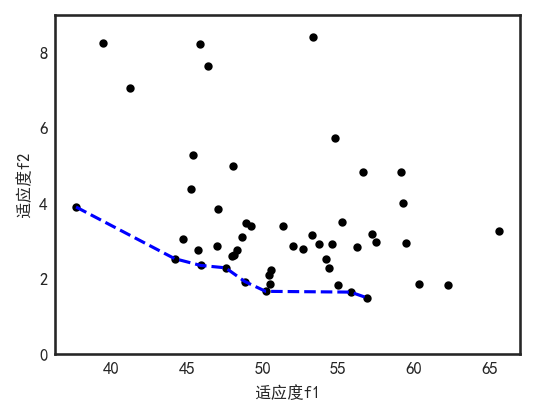

In [16]:
# 图4-8（a）
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(dpi=150,figsize=(4,3))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('适应度f1',size=8)
plt.ylabel('适应度f2',size=8)
plt.ylim(0,9)
temp = pd.DataFrame(np.array(z_REP),columns=['z1','z2'],index = num_parti)
temp2 = pd.DataFrame(np.array(z_ori),columns=['z1','z2'])
temp = temp.sort_values(by='z1')
plt.plot(temp2['z1'],temp2['z2'],'k.' )
plt.plot(temp['z1'],temp['z2'],'b--' )
# 标签
print('粒子标签从左到右分别为:')
print(np.array(temp.index))
#for i in range(0,len(z_REP)):#直接在图中标出
#    plt.text(z_REP[i][0]-1.5,z_REP[i][1],'Z ',fontsize=7)
#    plt.text(z_REP[i][0]-1.1,z_REP[i][1]-0.1,num_parti[i],fontsize=7)

In [17]:
# 表4-3 和 表4-4
print('***************** 路线(用于论文，站点id要＋1) &  投放量(用于论文，改变顺序)*****************')
for i in range(len(path_REP)):
    if num_parti[i] in [3,6,23,10,27]:
        print('         ')
        print('❀❀  Z'+str(num_parti[i])+'  ❀❀')
        print([i+1 for i in path_REP[i]])
        print('       ↑ 路线 ↑        ↓ 投放量↓')
        print([x_REP[i][k] for k in path_REP[i]])

print('***************** 适应度 *****************')
for i in range(len(z_REP)):
    if num_parti[i] in [3,6,23,10,27]:
        print('         ')
        print('❀❀  Z'+str(num_parti[i])+'  ❀❀')
        print(z_REP[i])
    

***************** 路线(用于论文，站点id要＋1) &  投放量(用于论文，改变顺序)*****************
         
❀❀  Z3  ❀❀
[1, 2, 3, 10, 21, 22, 38, 20, 25, 7, 23, 8, 17, 12, 13, 14, 15, 18, 16, 19, 34, 35, 39, 37, 36, 31, 30, 27, 5, 4, 11, 26, 29, 32, 6, 9, 33, 24, 28]
       ↑ 路线 ↑        ↓ 投放量↓
[0, -13, -3, 0, -9, -12, 3, 6, -1, 10, 6, -11, 1, -4, 5, 3, -6, 4, -7, -1, 2, 9, 10, -19, 6, -5, -11, 2, 8, 3, 1, 4, 3, -1, 5, 6, -1, 7, 0]
         
❀❀  Z6  ❀❀
[3, 1, 2, 10, 21, 38, 25, 20, 7, 8, 23, 13, 15, 17, 12, 24, 11, 32, 29, 26, 27, 6, 5, 30, 28, 31, 35, 37, 39, 36, 34, 33, 9, 4, 22, 18, 19, 16, 14]
       ↑ 路线 ↑        ↓ 投放量↓
[-5, 0, -13, -1, -10, 2, -1, 4, 9, -12, 5, 4, -6, 0, -5, 4, 2, -1, 3, 5, 1, 4, 10, -10, -14, -4, 11, -18, 11, 5, 2, 0, 8, 10, -11, 7, 2, -4, 6]
         
❀❀  Z10  ❀❀
[1, 2, 10, 21, 38, 20, 25, 12, 17, 8, 23, 13, 14, 15, 19, 18, 37, 39, 34, 35, 36, 28, 30, 27, 26, 32, 11, 4, 6, 29, 33, 7, 9, 22, 3, 16, 31, 5, 24]
       ↑ 路线 ↑        ↓ 投放量↓
[-12, -11, 1, -8, 4, 7, -1, -3, 2, -11, 7, 5, 4, -5, 0

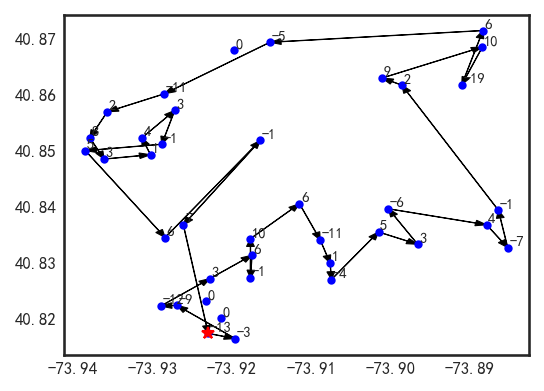

<Figure size 432x288 with 0 Axes>

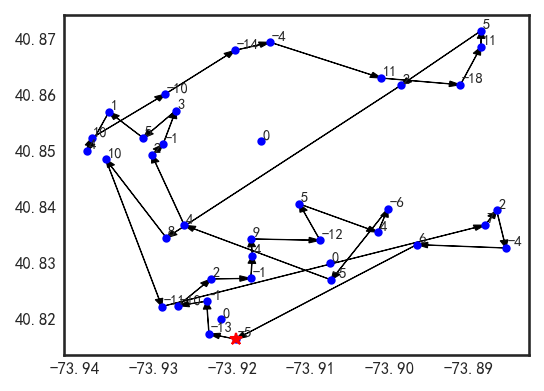

<Figure size 432x288 with 0 Axes>

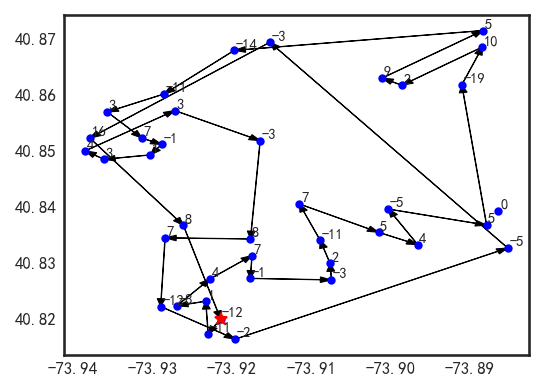

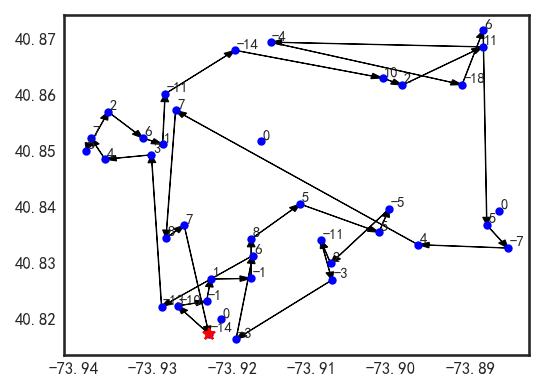

<Figure size 432x288 with 0 Axes>

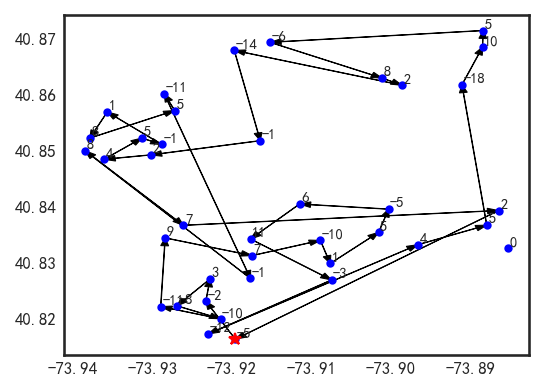

In [18]:
# 图4-8 
plt.rcParams['axes.unicode_minus']=False
    
# 画图  初代REP
for m in range(len(z_REP)):
    if num_parti[m] in [3,6,23,10,27]:
        plt.figure(dpi=150,figsize=(4,3))
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        path_id = path_REP[m]
        X = x_REP[m]
        lat2,lon2=[],[]
        for i in range(n):
            if X[path_id[i]]!=0:
                lat2.append(LAT_find[path_id[i]])
                lon2.append(LON_find[path_id[i]])
        for i in range(len(lon2)-1):
            plt.arrow(lon2[i],lat2[i],lon2[i+1]-lon2[i],lat2[i+1]-lat2[i],head_width=0.001,head_length=0.0014,width=0.0001,ec='k',fc='k',length_includes_head=True)
        plt.arrow(lon2[i+1],lat2[i+1],lon2[0]-lon2[i+1],lat2[0]-lat2[i+1],head_width=0.001,head_length=0.0014,width=0.0001,ec='k',fc='k',length_includes_head=True)
        plt.plot(LON_find,LAT_find,'b.')
        plt.plot(lon2[0],lat2[0],'r*')
        for i in range(len(X)):
            plt.text(LON_find[i]+0.0002,LAT_find[i]+0.0003,X[i],fontsize=7)
        plt.figure(m+2)

In [43]:
mutat_times = 10 # 迭代10*10=100次
Z_REP,PATH_REP,X_REP = [0 for x in range(10*mutat_times+1)],[0 for x in range(10*mutat_times+1)],[0 for x in range(10*mutat_times+1)]
Z_REP[0],PATH_REP[0],X_REP[0] = z_REP,path_REP,x_REP
for t in range(1,mutat_times+1):    
    # ----------------------------------------  变异 更新粒子  ------------------------------------------------
    for circle in [9,8,7,6,5,4,3,2,1]:
        print(t*10-circle)
        z_candidate,x_candidate,path_candidate = copy.deepcopy(z_pbest), copy.deepcopy(x_pbest), copy.deepcopy(path_pbest)
        for i in range(len(z_pbest)): 
            X = []
            for j in range(100):
                new_path = get_mutat(list(path_pbest[i]),random.randint(1,3))
                x = cp.Variable(n,integer = True)# 决策变量 整数
                obj = cp.Minimize(objective(x))
                cons1 = constri(new_path)
                exec(cons1)
                prob = cp.Problem(obj,con)#建立模型
                prob.solve(solver='ECOS_BB')
                if x.value is not None:
                    for k in x.value:
                        X.append(round(k))
                    break
            if len(X)> 0:
                path_candidate[i] = new_path
                x_candidate[i] = X        
                z_candidate[i] = get_many(X,new_path)
        # 更新 pbest 和 REP
        z_pbest,x_pbest,path_pbest = get_new_pbest(z_pbest,x_pbest,path_pbest,path_candidate,z_candidate,x_candidate)
        Z_REP[t*10-circle],PATH_REP[t*10-circle],X_REP[t*10-circle],num_parti = get_rep(z_pbest,path_pbest,x_pbest)
                
    ### ---------------------------------gbest 与 pbest 交叉，得【新candidate】 ------------------------------------
    print(t*10)
    gbest = PATH_REP[t*10-1][random.randint(0,len(Z_REP[t*10-1])-1)]#得【初始gbest】
    # 求解
    z_candidate,x_candidate,path_candidate = copy.deepcopy(z_pbest), copy.deepcopy(x_pbest), copy.deepcopy(path_pbest)
    for i in range(len(path_pbest)):
        pbest_i = path_pbest[i]
        X_O1,X_O2 = [],[]
        for j in range(40):
            O1,O2 = cross_particle(gbest,pbest_i)
            if len(X_O1) == 0: 
                x = cp.Variable(n,integer = True)# 决策变量 整数
                obj = cp.Minimize(objective(x))
                cons1 = constri(O1)
                exec(cons1)
                prob = cp.Problem(obj,con)#建立模型
                prob.solve(solver='ECOS_BB')
                if x.value is not None and sum(x.value)!=0:
                    for k in x.value:
                        X_O1.append(round(k))
                    path_O1 = copy.deepcopy(O1)
            if len(X_O2) == 0:
                x = cp.Variable(n,integer = True)# 决策变量 整数
                cons1 = constri(O2)
                exec(cons1)
                prob = cp.Problem(obj,con)#建立模型
                prob.solve(solver='ECOS_BB')
                if x.value is not None and sum(x.value)!=0:
                    for k in x.value:
                        X_O2.append(round(k))
                    path_O2 = copy.deepcopy(O2)
            if len(X_O1)>0 and len(X_O2)>0:
                break
        if len(X_O1)*len(X_O2)!=0:
            Z_O1,Z_O2 = get_many(X_O1,path_O1),get_many(X_O2,path_O2)
            # 比较 Q1 和 O2
            if (Z_O1[0]<Z_O2[0] and Z_O1[1]<=Z_O2[1]) or (Z_O1[0]<=Z_O2[0] and Z_O1[1]<Z_O2[1]):
                path_candidate[i],z_candidate[i],x_candidate[i]=path_O1,Z_O1,X_O1
            else:# O2支配O1 或者 随机二选一，都选O2，反正都是随机的结果
                path_candidate[i],z_candidate[i],x_candidate[i]=path_O2,Z_O2,X_O2       
    ###  与xx_candidate比较，更新pbest、  更新REP
    z_pbest,x_pbest,path_pbest = get_new_pbest(z_pbest,x_pbest,path_pbest,path_candidate,z_candidate,x_candidate)
    Z_REP[t*10],PATH_REP[t*10],X_REP[t*10],num_parti = get_rep(z_pbest,path_pbest,x_pbest) 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [48]:
# 存入
pd.DataFrame(np.array(Z_REP)).to_csv('E:/CitiBike/y5_output/Z_REP.csv')
pd.DataFrame(np.array(X_REP)).to_csv('E:/CitiBike/y5_output/X_REP.csv')
pd.DataFrame(np.array(PATH_REP)).to_csv('E:/CitiBike/y5_output/PATH_REP.csv')
pd.DataFrame(np.array(x_pbest)).to_csv('E:/CitiBike/y5_output/x_pbest.csv')
pd.DataFrame(np.array(z_pbest)).to_csv('E:/CitiBike/y5_output/z_pbest.csv')
pd.DataFrame(np.array(path_pbest)).to_csv('E:/CitiBike/y5_output/path_pbest.csv')

In [19]:
'''
# 以上程序运行的久，结果已存，可直接读取  
x_pbest =np.array(pd.read_csv('E:/CitiBike/y5_output/x_pbest.csv',index_col=0))
z_pbest = np.array(pd.read_csv('E:/CitiBike/y5_output/z_pbest.csv',index_col=0))
path_pbest = np.array(pd.read_csv('E:/CitiBike/y5_output/path_pbest.csv',index_col=0))
x_pbest,z_pbest,path_pbest = [list(x) for x in x_pbest],[list(x) for x in z_pbest],[list(x) for x in path_pbest]
X_REP = np.array(pd.read_csv('E:/CitiBike/y5_output/X_REP.csv',index_col=0))
Z_REP = np.array(pd.read_csv('E:/CitiBike/y5_output/Z_REP.csv',index_col=0))
PATH_REP = np.array(pd.read_csv('E:/CitiBike/y5_output/PATH_REP.csv',index_col=0))
X_REP,Z_REP,PATH_REP = [list(x) for x in X_REP],[list(x) for x in Z_REP],[list(x) for x in PATH_REP]
for i in range(len(X_REP)):
    exec('X_REP['+str(i)+']='+str(X_REP[i][0]))
    exec('Z_REP['+str(i)+']='+str(Z_REP[i][0]))
    exec('PATH_REP['+str(i)+']='+str(PATH_REP[i][0]))

In [20]:
# REP的更新
REP_iteration = [z_REP]
index_list = get_rep(z_ori,path_ori,x_ori)[3]
z_REP0,x_REP0,path_REP0 = copy.deepcopy(z_REP),copy.deepcopy(x_REP),copy.deepcopy(path_REP)
for t in range(1,101):
    for i in range(len(Z_REP[t])):
        if Z_REP[t][i] not in z_REP0:
            z_REP0.append(Z_REP[t][i])
            x_REP0.append(X_REP[t][i])
            path_REP0.append(PATH_REP[t][i])
            index_list.append(i)
    temp_z,temp_path,temp_x,temp_num = get_rep(z_REP0,path_REP0,x_REP0)
    REP_iteration.append([x for x in temp_z if x[1]<4.5])#REP_iteration.append(temp_z)

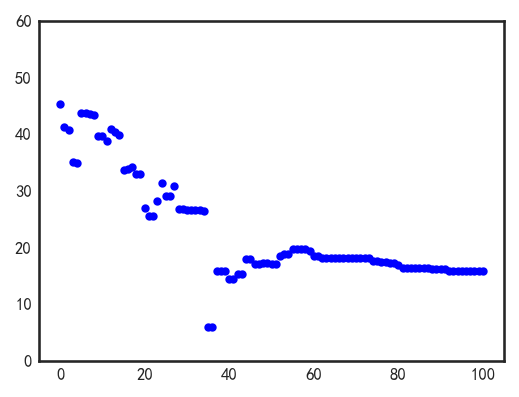

In [22]:
# 100次 迭代  面积效果图  图4-9
plt.figure(dpi=150,figsize=(4,3))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)# 画图设置

area = []
for i in range(len(REP_iteration)):
    temp = pd.DataFrame(np.array(REP_iteration[i]),columns=['z1','z2'])
    temp = temp.sort_values('z1')
    S = 0
    for j in range(len(temp)-1):
        S += ((list(temp['z2'])[j]+list(temp['z2'])[j+1])*(list(temp['z1'])[j+1]-list(temp['z1'])[j]))/2
    area.append(S)
plt.ylim(0,60)
plt.plot(area,'b.')

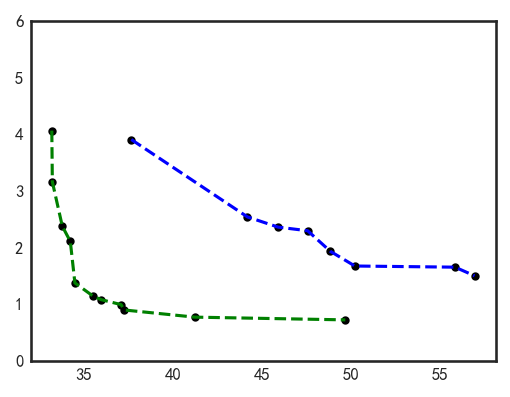

In [23]:
# 图4-10
plt.figure(dpi=150,figsize=(4,3))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)# 画图设置

# 初始——最终 对比
temp = pd.DataFrame(np.array(REP_iteration[0]),columns=['z1','z2'])
temp = temp.sort_values('z1')
plt.ylim(0,6)
plt.plot(temp['z1'],temp['z2'],'k.')
plt.plot(temp['z1'],temp['z2'],'b--')

temp = pd.DataFrame(np.array(REP_iteration[100]),columns=['z1','z2'])
temp = temp.sort_values('z1')
plt.plot(temp['z1'],temp['z2'],'k.')
plt.plot(temp['z1'],temp['z2'],'g--')


In [24]:
#最终REP  表4-5
temp = pd.DataFrame(np.array(REP_iteration[100]),columns=['z1','z2']).sort_values(by='z1')
temp.index = ['R'+str(i) for i in range(len(REP_iteration[100]))]
# C_tota
C_e = 0.12 #货车每 一千米 的耗油（升）
C_d = 2 #每损失一个需求的惩罚 1.5+0.2  其中0.2是下次使用预期和本次超时预期
C_p = 8 # 油价/每升
temp['C_total']=temp['z1']*C_e*C_p + temp['z2']*C_d
temp

,z1,z2,C_total
R0,33.197854,4.063817,39.997575
R1,33.227929,3.160281,38.219374
R2,33.786113,2.375332,37.185333
R3,34.235551,2.107114,37.080356
R4,34.492572,1.374081,35.861030
R5,35.522870,1.138044,36.378043
R6,35.976255,1.077545,36.692294
R7,37.080905,0.991137,37.579944
R8,37.261614,0.895794,37.562738
R9,41.211403,0.769499,41.101945


In [25]:
for i in range(len(temp_z)):
    if temp_z[i][0] == temp['z1']['R4'] and temp_z[i][1] == temp['z2']['R4']:
        print('投放路径(写论文里的，站点要＋1)：')
        print([k+1 for k in temp_path[i]])
        print('投放路径(后面要用)：')
        print(temp_path[i])
        print('取/放单车数量(写论文里的，顺序符合路径)：')
        print([temp_x[i][k] for k in temp_path[i]])
        print('取/放单车数量(后面要用)：')
        print(temp_x[i])
        print('适应度f1，f2')
        print(np.array(temp_z[i]))
        break

投放路径(写论文里的，站点要＋1)：
[10, 3, 1, 2, 21, 22, 38, 25, 7, 20, 23, 8, 17, 12, 13, 14, 15, 18, 16, 19, 34, 35, 37, 36, 39, 31, 30, 27, 5, 4, 6, 26, 11, 32, 33, 28, 29, 24, 9]
投放路径(后面要用)：
[9, 2, 0, 1, 20, 21, 37, 24, 6, 19, 22, 7, 16, 11, 12, 13, 14, 17, 15, 18, 33, 34, 36, 35, 38, 30, 29, 26, 4, 3, 5, 25, 10, 31, 32, 27, 28, 23, 8]
取/放单车数量(写论文里的，顺序符合路径)：
[-1, -2, -9, -10, -7, -10, 4, 0, 11, 5, 6, -11, 1, -3, 5, 3, -5, 5, -7, 0, 3, 9, -18, 5, 9, -5, -11, 2, 7, 2, 4, 5, 2, 1, 0, -14, 7, 7, 10]
取/放单车数量(后面要用)：
[-9, -10, -2, 2, 7, 4, 11, -11, 10, -1, 2, -3, 5, 3, -5, -7, 1, 5, 0, 5, -7, -10, 6, 7, 0, 5, 2, -14, 7, -11, -5, 1, 0, 3, 9, 5, -18, 4, 9]
适应度f1，f2
[34.49257174  1.37408078]


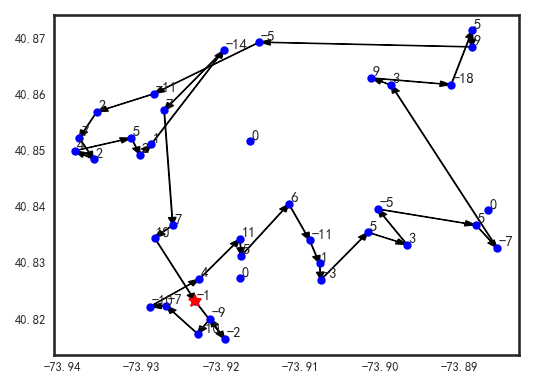

In [26]:
# 图4-11
plt.figure(dpi=150,figsize=(4,3))
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
path_id = [9, 2, 0, 1, 20, 21, 37, 24, 6, 19, 22, 7, 16, 11, 12, 13, 14, 17, 15, 18, 33, 34, 36, 35, 38, 30, 29, 26, 4, 3, 5, 25, 10, 31, 32, 27, 28, 23, 8]
X =[-9, -10, -2, 2, 7, 4, 11, -11, 10, -1, 2, -3, 5, 3, -5, -7, 1, 5, 0, 5, -7, -10, 6, 7, 0, 5, 2, -14, 7, -11, -5, 1, 0, 3, 9, 5, -18, 4, 9]
lat2,lon2=[],[]
for i in range(n):
    if X[path_id[i]]!=0:
        lat2.append(LAT_find[path_id[i]])
        lon2.append(LON_find[path_id[i]])
for i in range(len(lon2)-1):
    plt.arrow(lon2[i],lat2[i],lon2[i+1]-lon2[i],lat2[i+1]-lat2[i],head_width=0.001,head_length=0.0014,width=0.0001,ec='k',fc='k',length_includes_head=True)
plt.arrow(lon2[i+1],lat2[i+1],lon2[0]-lon2[i+1],lat2[0]-lat2[i+1],head_width=0.001,head_length=0.0014,width=0.0001,ec='k',fc='k',length_includes_head=True)
plt.plot(LON_find,LAT_find,'b.')
plt.plot(lon2[0],lat2[0],'r*')
for i in range(len(X)):
    plt.text(LON_find[i]+0.0002,LAT_find[i]+0.0003,X[i],fontsize=7)